Nb features AVANT ingénierie : 40
Distribution des classes :
target_is_fraud
0    155076
1      4924
Name: count, dtype: int64
  → Ratio fraude : 3.08%

Ajout de ratios intelligents...
Ratios ajoutés : []
Nb features APRÈS ingénierie : 40

Taille X_train : (128000, 40)  |  X_val : (32000, 40)
Fraudes dans y_train : 3939 (3.08%)
Fraudes dans y_val   : 985 (3.08%)

Calcul de l'importance des features avec LightGBM...
scale_pos_weight = 31.50 (ratio non-fraude/fraude)

Top 30 features les plus importantes :
                feature  importance
              ip_risk_z         185
         device_trust_z         167
      internal_signal_5         148
       max_to_avg_ratio         133
      internal_signal_3         131
       account_age_days         130
      credit_score_norm         128
      internal_signal_4         126
      internal_signal_1         125
      internal_signal_8         122
      internal_signal_7         119
      internal_signal_2         117
      internal_signal_

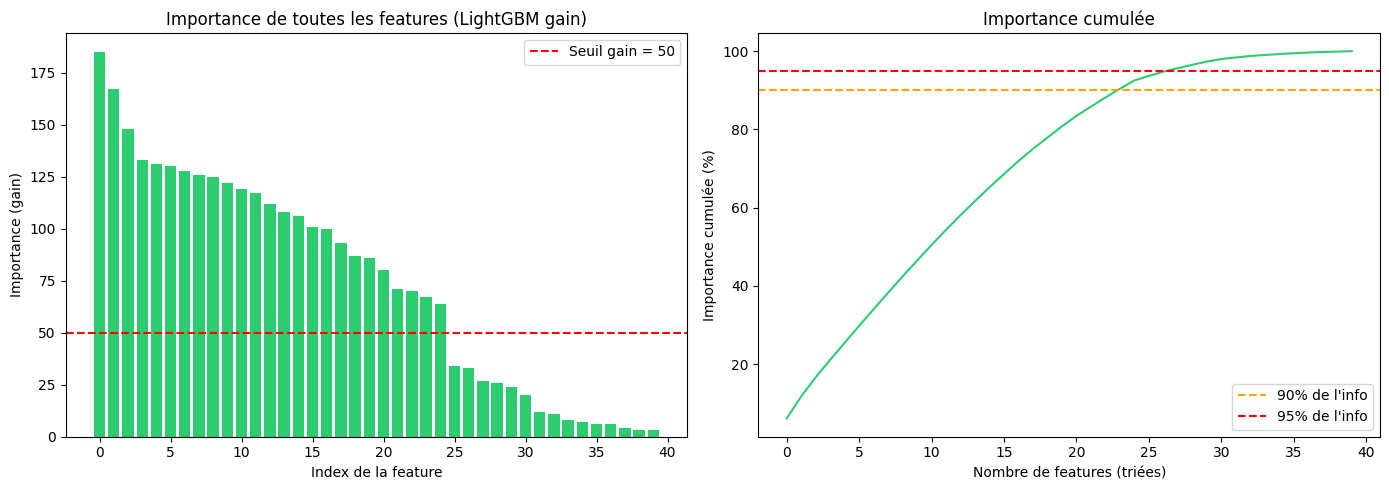


[Graphique sauvegardé → feature_importance_lightgbm.png]

Nb features APRÈS sélection : 25

Entraînement du modèle LightGBM optimisé...
Meilleur nombre d'arbres (early stopping) : 1
AUC sur validation : 0.6306

Optimisation du seuil de décision...
Seuil par défaut : 0.5
Seuil optimal    : 0.055 (F1 = 0.0976)


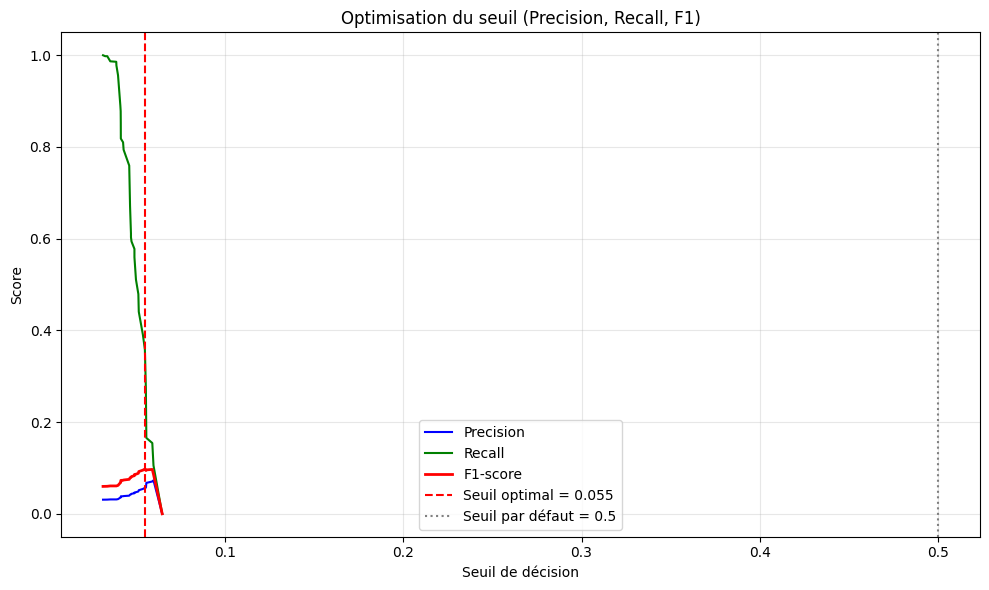

[Graphique sauvegardé → threshold_optimization.png]

════════════════════════════════════════════════════════════
RÉSULTATS AVEC SEUIL PAR DÉFAUT (0.5)
════════════════════════════════════════════════════════════
Confusion Matrix :
[[31015     0]
 [  985     0]]

Classification Report :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     31015
           1       0.00      0.00      0.00       985

    accuracy                           0.97     32000
   macro avg       0.48      0.50      0.49     32000
weighted avg       0.94      0.97      0.95     32000


════════════════════════════════════════════════════════════
RÉSULTATS AVEC SEUIL OPTIMISÉ (0.055)
════════════════════════════════════════════════════════════
Confusion Matrix :
[[25117  5898]
 [  632   353]]

Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     31015
           1       0.06      0.36      0

c:\Users\yannc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yannc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yannc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [3]:
"""
====================================================================
SÉLECTION DE FEATURES + LightGBM avec scale_pos_weight
====================================================================
Objectif : Détecter la fraude avec LightGBM plutôt que Random Forest,
           en gérant le déséquilibre via scale_pos_weight (PAS de SMOTE).

Pourquoi LightGBM > Random Forest pour la fraude ?
  ✓ Plus rapide sur gros datasets
  ✓ Gère mieux les features catégorielles
  ✓ Moins d'overfitting grâce au learning_rate faible + early stopping
  ✓ scale_pos_weight natif pour le déséquilibre (pas besoin de SMOTE)

Stratégie scale_pos_weight :
  scale_pos_weight = (nb non-fraude) / (nb fraude)
  → pénalise plus les erreurs sur la classe minoritaire
  → équivalent à class_weight='balanced' mais optimisé pour gradient boosting

Pipeline :
  1. Ajout de ratios intelligents (détection d'anomalies comportementales)
  2. Split train / val
  3. Calcul de l'importance des features (LightGBM rapide)
  4. Sélection des features
  5. GridSearch avec early stopping
  6. Optimisation du seuil de décision (0.5 n'est PAS optimal pour fraude !)
  7. Évaluation finale
====================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, f1_score, roc_auc_score
)

# pip install lightgbm  (si pas encore installé)


# ──────────────────────────────────────────────────────────────────
# 0. CHARGEMENT DES DONNÉES
# ──────────────────────────────────────────────────────────────────

train = pd.read_csv('../6.Data/Yann_Process_train.csv')
test  = pd.read_csv('../6.Data/Yann_Process_test.csv')

target = 'target_is_fraud'
id_col = 'customer_id'

X = train.drop(columns=[target, id_col])
y = train[target]
X_test = test.drop(columns=[id_col])

print(f"Nb features AVANT ingénierie : {X.shape[1]}")
print(f"Distribution des classes :\n{y.value_counts()}")
print(f"  → Ratio fraude : {y.mean()*100:.2f}%\n")


# ──────────────────────────────────────────────────────────────────
# 1. AJOUT DE RATIOS INTELLIGENTS (Feature Engineering)
#    Ces ratios détectent des anomalies comportementales fréquentes
#    dans la fraude :
#      - Transactions disproportionnées par rapport à l'historique
#      - Comportement inhabituel (vitesse, fréquence, montants)
#      - Écarts par rapport aux moyennes du compte
#
#    Adapte ces exemples à TES colonnes réelles !
#    Cherche dans ton dataset :
#      - montant de transaction : amount, transaction_amount, etc.
#      - moyennes / totaux : avg_amount, total_spent, etc.
#      - fréquences : nb_transactions, transaction_count, etc.
#      - temporalité : time_since_last, days_since_first, etc.
# ──────────────────────────────────────────────────────────────────

def add_intelligent_ratios(df):
    """
    Ajoute 3–5 ratios intelligents pour détecter les fraudes.
    
    ⚠ ADAPTE CES NOMS DE COLONNES À TON DATASET !
    Exemples ci-dessous basés sur des colonnes hypothétiques.
    """
    df = df.copy()
    
    # Exemple 1 : Ratio transaction actuelle / moyenne historique
    # → Détecte les transactions anormalement élevées
    if 'transaction_amount' in df.columns and 'avg_transaction_amount' in df.columns:
        df['ratio_amount_vs_avg'] = (
            df['transaction_amount'] / (df['avg_transaction_amount'] + 1e-6)
        )
    
    # Exemple 2 : Ratio transaction / solde du compte
    # → Détecte les tentatives de vider le compte
    if 'transaction_amount' in df.columns and 'account_balance' in df.columns:
        df['ratio_amount_vs_balance'] = (
            df['transaction_amount'] / (df['account_balance'] + 1e-6)
        )
    
    # Exemple 3 : Vitesse des transactions (nb transactions / jours actifs)
    # → Détecte les pics d'activité suspects
    if 'nb_transactions_30d' in df.columns and 'days_active_30d' in df.columns:
        df['ratio_txn_velocity'] = (
            df['nb_transactions_30d'] / (df['days_active_30d'] + 1e-6)
        )
    
    # Exemple 4 : Écart au montant médian du compte
    # → Détecte les montants inhabituels pour ce client
    if 'transaction_amount' in df.columns and 'median_transaction_amount' in df.columns:
        df['ratio_amount_vs_median'] = (
            df['transaction_amount'] / (df['median_transaction_amount'] + 1e-6)
        )
    
    # Exemple 5 : Ratio échecs / total tentatives (si dispo)
    # → Les fraudeurs essaient souvent plusieurs cartes
    if 'nb_failed_transactions' in df.columns and 'nb_total_transactions' in df.columns:
        df['ratio_failed_txn'] = (
            df['nb_failed_transactions'] / (df['nb_total_transactions'] + 1e-6)
        )
    
    return df

# Application sur train et test
print("Ajout de ratios intelligents...")
X = add_intelligent_ratios(X)
X_test = add_intelligent_ratios(X_test)

new_features = [col for col in X.columns if col.startswith('ratio_')]
print(f"Ratios ajoutés : {new_features}")
print(f"Nb features APRÈS ingénierie : {X.shape[1]}\n")


# ──────────────────────────────────────────────────────────────────
# 2. SPLIT TRAIN / VALIDATION
# ──────────────────────────────────────────────────────────────────

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Taille X_train : {X_train.shape}  |  X_val : {X_val.shape}")
print(f"Fraudes dans y_train : {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Fraudes dans y_val   : {y_val.sum()} ({y_val.mean()*100:.2f}%)\n")


# ──────────────────────────────────────────────────────────────────
# 3. CALCUL DE L'IMPORTANCE DES FEATURES (LightGBM rapide)
# ──────────────────────────────────────────────────────────────────

print("Calcul de l'importance des features avec LightGBM...")

# Calcul du scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight = {scale_pos_weight:.2f} (ratio non-fraude/fraude)\n")

selector_lgb = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
selector_lgb.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'feature':    X_train.columns,
    'importance': selector_lgb.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 30 features les plus importantes :")
print(importance_df.head(30).to_string(index=False))


# ──────────────────────────────────────────────────────────────────
# 4. VISUALISATION DES IMPORTANCES
# ──────────────────────────────────────────────────────────────────

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(importance_df)), importance_df['importance'], color='#2ecc71')
plt.axhline(y=50, color='red', linestyle='--', label='Seuil gain = 50')
plt.xlabel('Index de la feature')
plt.ylabel('Importance (gain)')
plt.title('Importance de toutes les features (LightGBM gain)')
plt.legend()

plt.subplot(1, 2, 2)
cumulative = importance_df['importance'].cumsum()
cumulative_norm = cumulative / cumulative.iloc[-1]
plt.plot(range(len(importance_df)), cumulative_norm * 100, color='#2ecc71')
plt.axhline(y=90, color='orange', linestyle='--', label="90% de l'info")
plt.axhline(y=95, color='red',    linestyle='--', label="95% de l'info")
plt.xlabel('Nombre de features (triées)')
plt.ylabel('Importance cumulée (%)')
plt.title('Importance cumulée')
plt.legend()

plt.tight_layout()
plt.savefig('../6.Data/feature_importance_lightgbm.png', dpi=150)
plt.show()
print("\n[Graphique sauvegardé → feature_importance_lightgbm.png]")


# ──────────────────────────────────────────────────────────────────
# 5. SÉLECTION DES FEATURES
#
#    Pour LightGBM, on utilise le "gain" (réduction de la loss).
#    Seuil typique : gain > 50 ou top 30–50 features.
# ──────────────────────────────────────────────────────────────────

# -- MÉTHODE A : par seuil de gain --
GAIN_THRESHOLD = 50
selected_features = importance_df[importance_df['importance'] >= GAIN_THRESHOLD]['feature'].tolist()

# -- MÉTHODE B : top N features (décommente pour utiliser) --
# TOP_N = 40
# selected_features = importance_df.head(TOP_N)['feature'].tolist()

print(f"\nNb features APRÈS sélection : {len(selected_features)}")

X_train_sel = X_train[selected_features]
X_val_sel   = X_val[selected_features]
X_test_sel  = X_test[selected_features]


# ──────────────────────────────────────────────────────────────────
# 6. ENTRAÎNEMENT LightGBM AVEC EARLY STOPPING
#    Stratégie pour la fraude :
#      - Beaucoup d'arbres (500–1000) avec learning_rate faible (0.01–0.05)
#        → apprentissage graduel, moins d'overfitting
#      - max_depth modéré (4–8) pour éviter la mémorisation
#      - early_stopping pour s'arrêter au bon moment
# ──────────────────────────────────────────────────────────────────

print("\nEntraînement du modèle LightGBM optimisé...")

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,              # beaucoup d'arbres
    learning_rate=0.03,             # learning_rate faible
    max_depth=6,
    num_leaves=31,                  # 2^max_depth - 1
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,                  # bagging pour réduire l'overfitting
    colsample_bytree=0.8,           # feature sampling
    min_child_samples=20,           # min exemples par feuille
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Callbacks pour early stopping
callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=False),
    lgb.log_evaluation(period=0)  # pas de logs
]

lgb_model.fit(
    X_train_sel, y_train,
    eval_set=[(X_val_sel, y_val)],
    eval_metric='auc',
    callbacks=callbacks
)

print(f"Meilleur nombre d'arbres (early stopping) : {lgb_model.best_iteration_}")
print(f"AUC sur validation : {lgb_model.best_score_['valid_0']['auc']:.4f}")


# ──────────────────────────────────────────────────────────────────
# 7. OPTIMISATION DU SEUIL DE DÉCISION
#    Par défaut, sklearn prédit 1 si proba > 0.5.
#    Pour la fraude, ce n'est PAS optimal !
#    On cherche le seuil qui maximise le F1-score.
# ──────────────────────────────────────────────────────────────────

print("\nOptimisation du seuil de décision...")

y_proba = lgb_model.predict_proba(X_val_sel)[:, 1]

# Calcul du F1 pour chaque seuil possible
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Seuil optimal = celui qui maximise F1
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Seuil par défaut : 0.5")
print(f"Seuil optimal    : {best_threshold:.3f} (F1 = {best_f1:.4f})")

# Visualisation courbe Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.plot(thresholds, f1_scores[:-1], label='F1-score', color='red', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Seuil optimal = {best_threshold:.3f}')
plt.axvline(x=0.5, color='gray', linestyle=':', label='Seuil par défaut = 0.5')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.title('Optimisation du seuil (Precision, Recall, F1)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../6.Data/threshold_optimization.png', dpi=150)
plt.show()
print("[Graphique sauvegardé → threshold_optimization.png]\n")


# ──────────────────────────────────────────────────────────────────
# 8. ÉVALUATION AVEC SEUIL OPTIMISÉ
# ──────────────────────────────────────────────────────────────────

y_pred_default = lgb_model.predict(X_val_sel)          # seuil 0.5
y_pred_optimal = (y_proba >= best_threshold).astype(int)  # seuil optimisé

print("═" * 60)
print("RÉSULTATS AVEC SEUIL PAR DÉFAUT (0.5)")
print("═" * 60)
print('Confusion Matrix :')
print(confusion_matrix(y_val, y_pred_default))
print('\nClassification Report :')
print(classification_report(y_val, y_pred_default))

print("\n" + "═" * 60)
print(f"RÉSULTATS AVEC SEUIL OPTIMISÉ ({best_threshold:.3f})")
print("═" * 60)
print('Confusion Matrix :')
print(confusion_matrix(y_val, y_pred_optimal))
print('\nClassification Report :')
print(classification_report(y_val, y_pred_optimal))

# Métriques supplémentaires
auc_score = roc_auc_score(y_val, y_proba)
print(f"\nAUC-ROC : {auc_score:.4f}")


# ──────────────────────────────────────────────────────────────────
# 9. EXPORT DES RÉSULTATS
# ──────────────────────────────────────────────────────────────────

importance_df.to_csv('../6.Data/feature_importance_ranking_lightgbm.csv', index=False)

# Sauvegarde du seuil optimal pour réutilisation
with open('../6.Data/optimal_threshold.txt', 'w') as f:
    f.write(f"{best_threshold:.4f}")

print("\n[Fichiers sauvegardés :")
print("  → feature_importance_ranking_lightgbm.csv")
print("  → optimal_threshold.txt]")


# ──────────────────────────────────────────────────────────────────
# 10. PRÉDICTIONS SUR TEST (avec seuil optimisé)
# ──────────────────────────────────────────────────────────────────

print("\nGénération des prédictions sur test...")

test_proba = lgb_model.predict_proba(X_test_sel)[:, 1]
test_pred = (test_proba >= best_threshold).astype(int)

submission = pd.DataFrame({
    id_col: test[id_col],
    'prediction': test_pred,
    'probability': test_proba
})

submission.to_csv('../6.Data/lightgbm_predictions.csv', index=False)
print("[Prédictions sauvegardées → lightgbm_predictions.csv]")
print(f"\nNb de fraudes prédites : {test_pred.sum()} / {len(test_pred)} ({test_pred.mean()*100:.2f}%)")

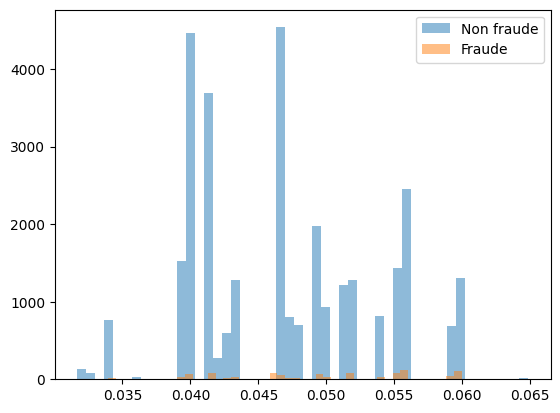

In [4]:
import matplotlib.pyplot as plt

plt.hist(y_proba[y_val==0], bins=50, alpha=0.5, label="Non fraude")
plt.hist(y_proba[y_val==1], bins=50, alpha=0.5, label="Fraude")
plt.legend()
plt.show()
